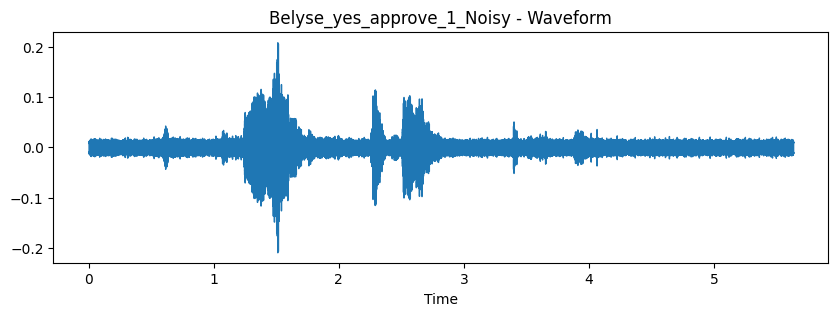

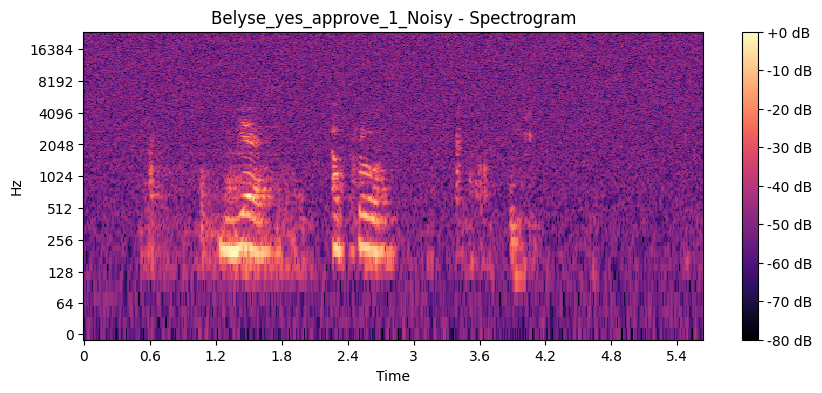

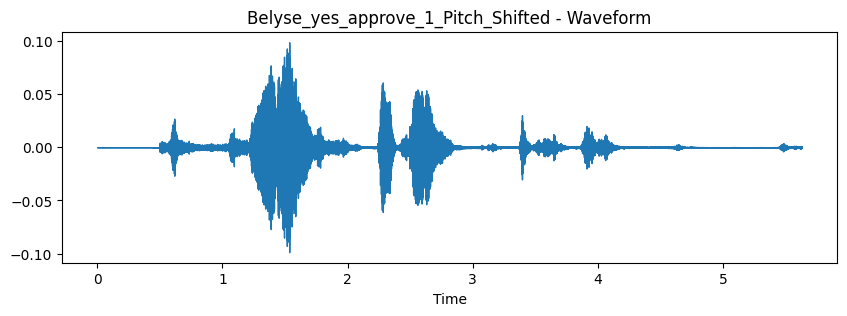

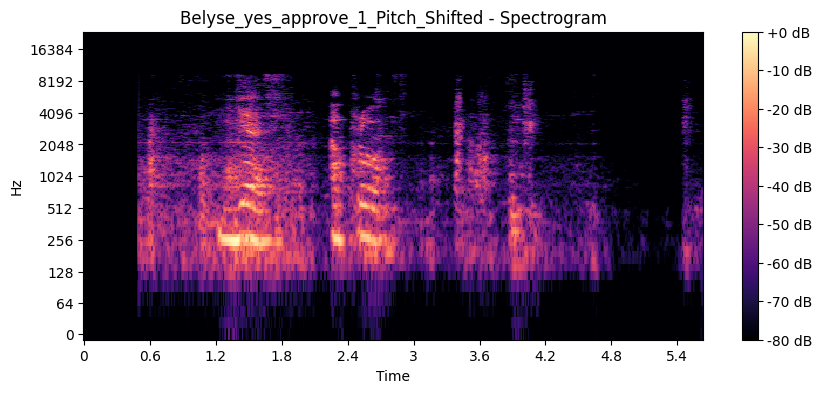

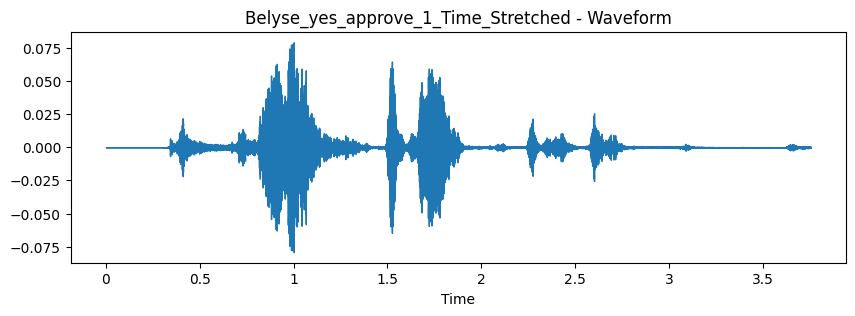

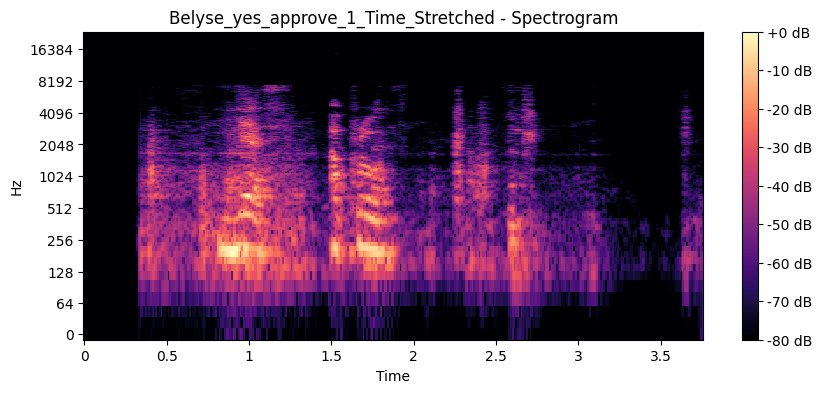

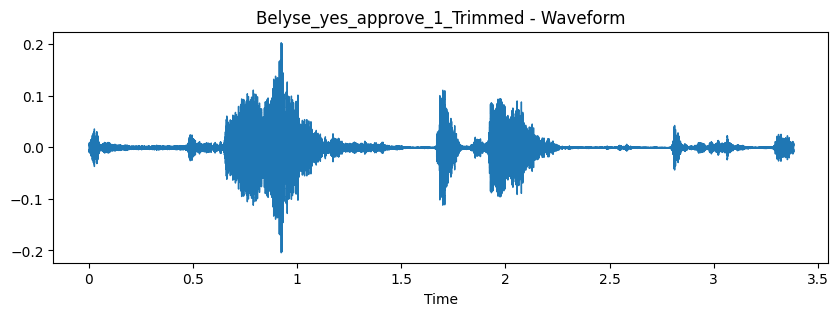

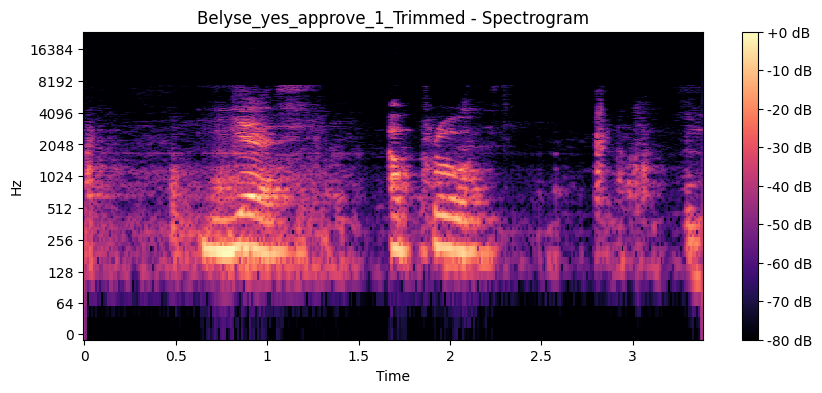

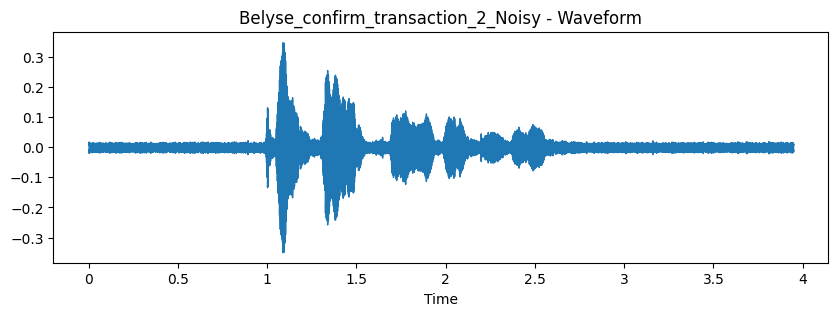

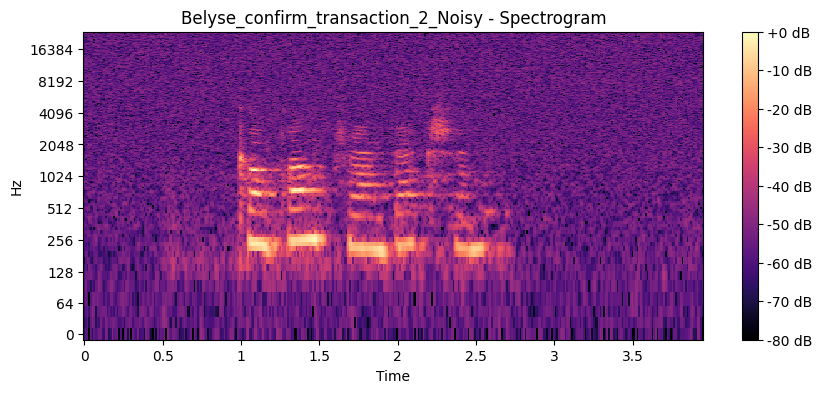

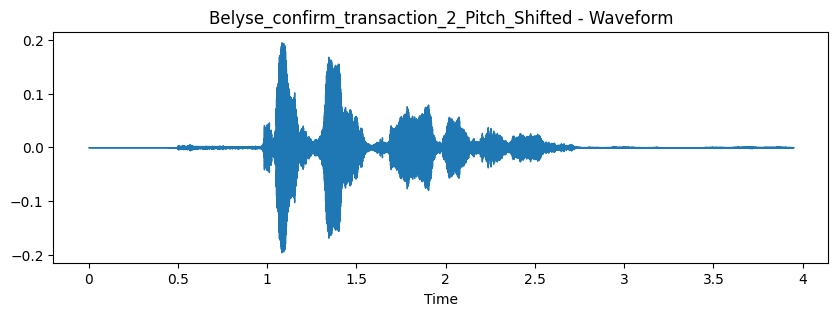

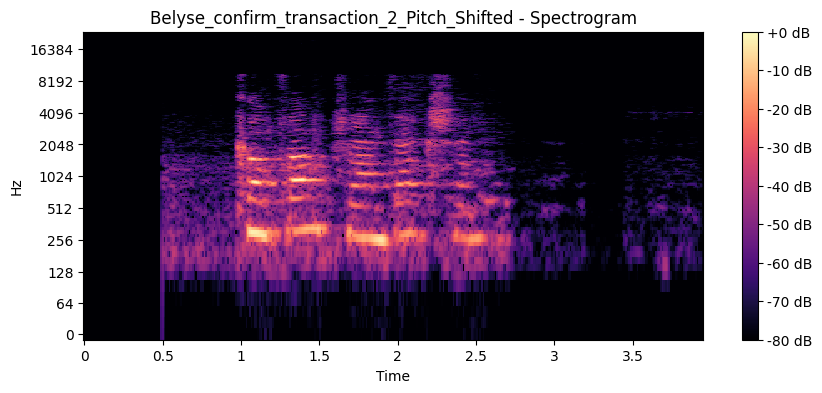

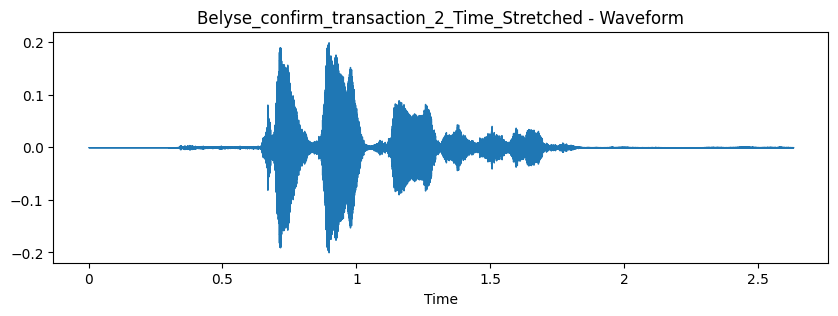

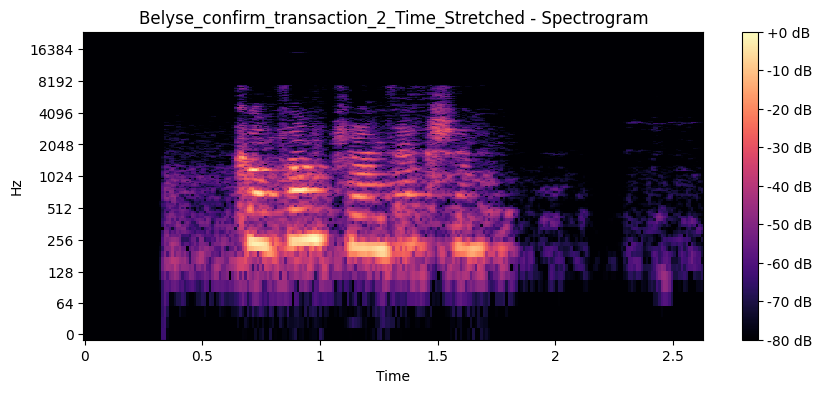

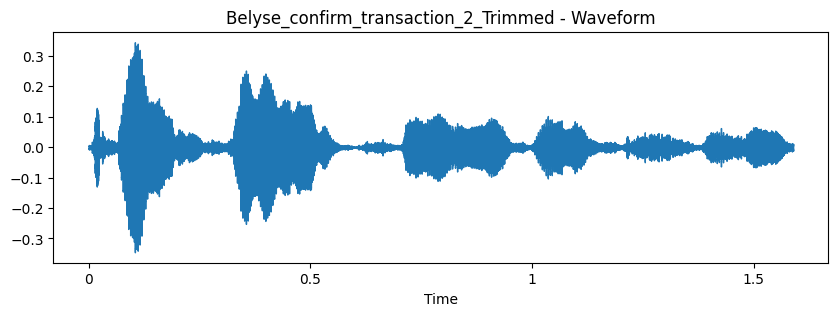

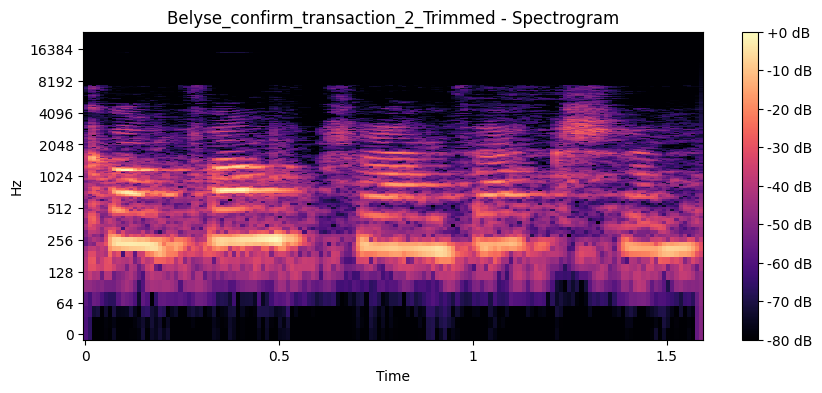

✅ Saved: /home/belysetag/Documents/Formative-2-Data-Preprocessing/data_processed/processed_audio_files/Belyse_yes_approve_1_Noisy.wav
✅ Saved: /home/belysetag/Documents/Formative-2-Data-Preprocessing/data_processed/processed_audio_files/Belyse_yes_approve_1_Pitch_Shifted.wav
✅ Saved: /home/belysetag/Documents/Formative-2-Data-Preprocessing/data_processed/processed_audio_files/Belyse_yes_approve_1_Time_Stretched.wav
✅ Saved: /home/belysetag/Documents/Formative-2-Data-Preprocessing/data_processed/processed_audio_files/Belyse_yes_approve_1_Trimmed.wav
✅ Saved: /home/belysetag/Documents/Formative-2-Data-Preprocessing/data_processed/processed_audio_files/Belyse_confirm_transaction_2_Noisy.wav
✅ Saved: /home/belysetag/Documents/Formative-2-Data-Preprocessing/data_processed/processed_audio_files/Belyse_confirm_transaction_2_Pitch_Shifted.wav
✅ Saved: /home/belysetag/Documents/Formative-2-Data-Preprocessing/data_processed/processed_audio_files/Belyse_confirm_transaction_2_Time_Stretched.wav
✅ 

In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import pandas as pd
from pathlib import Path

# Define paths

audio_paths = [
    "/home/belysetag/Documents/Formative-2-Data-Preprocessing/data/audio_data/belyse/yes_approve.wav",
    "/home/belysetag/Documents/Formative-2-Data-Preprocessing/data/audio_data/belyse/confirm_transaction.wav"
]

output_dir = Path("/home/belysetag/Documents/Formative-2-Data-Preprocessing/data_processed/processed_audio_files")
output_dir.mkdir(parents=True, exist_ok=True)

# Audio Augmentation

augmented_audios = []
for idx, path in enumerate(audio_paths, start=1):
    basename = os.path.splitext(os.path.basename(path))[0]
    y, sr = librosa.load(path, sr=None)

    # Noise Injection
    noise = np.random.randn(len(y))
    y_noise = y + 0.005 * noise
    augmented_audios.append((y_noise, sr, f"Belyse_{basename}_{idx}_Noisy"))

    # Pitch Shift
    y_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=4)
    augmented_audios.append((y_pitch, sr, f"Belyse_{basename}_{idx}_Pitch_Shifted"))
    
    # Time Stretch
    y_stretch = librosa.effects.time_stretch(y, rate=1.5)
    augmented_audios.append((y_stretch, sr, f"Belyse_{basename}_{idx}_Time_Stretched"))

    # Trim Silence
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)
    augmented_audios.append((y_trimmed, sr, f"Belyse_{basename}_{idx}_Trimmed"))


# Visualization (Waveform + Spectrogram)

for y_aug, sr, aug_type in augmented_audios:
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(y_aug, sr=sr)
    plt.title(f"{aug_type} - Waveform")
    plt.show()

    D = librosa.amplitude_to_db(np.abs(librosa.stft(y_aug)), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"{aug_type} - Spectrogram")
    plt.show()


# Save Augmented Audio Files

for y_aug, sr, aug_type in augmented_audios:
    output_path = output_dir / f"{aug_type}.wav"
    sf.write(output_path, y_aug, sr)
    print(f"✅ Saved: {output_path}")

# Feature Extraction & CSV Export

feature_list = []

for y_aug, sr, aug_type in augmented_audios:
    # Compute features
    mfccs = librosa.feature.mfcc(y=y_aug, sr=sr, n_mfcc=13)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y_aug, sr=sr)
    rms = librosa.feature.rms(y=y_aug)

    # Mean values
    mfccs_mean = np.mean(mfccs, axis=1)
    rolloff_mean = np.mean(spectral_rolloff)
    energy_mean = np.mean(rms)

    # Build feature dictionary with MFCCs as separate columns
    feature_data = {'Augmentation': aug_type}
    feature_data.update({f"MFCC_{i+1}_Mean": val for i, val in enumerate(mfccs_mean)})
    feature_data['Spectral_Rolloff_Mean'] = rolloff_mean
    feature_data['Energy'] = energy_mean

    feature_list.append(feature_data)

# Create DataFrame and save
df = pd.DataFrame(feature_list)
output_csv = Path("/home/belysetag/Documents/Formative-2-Data-Preprocessing/data_processed/audio/audio_features.csv")
df.to_csv(output_csv, index=False)
print(f"✅ Features saved to: {output_csv}")
